# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('/home/jovyan/data_preprocessing')

### Set file paths

In [ ]:
file_comments = "../../data/raw_data/Ask_Politics_comments.zst"
file_submissions = "../../data/raw_data/Ask_Politics_submissions.zst"

subreddit_here = "Ask_Politics"
subreddit = "Ask_Politics"


output_path = f"../../data/new_preprocessing/{subreddit_here}_new_preprocessing_com_rep.csv"



In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time

pd.options.mode.chained_assignment = None

In [5]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [6]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [7]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [8]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 47176


In [9]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 532593


In [10]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 180846
Nr. of replies 98737


### Filter relevant submissions

* relevant_comments: those with a parent, that is in relevant_submissions

In [11]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions

4.448746648298934


,submission_id,count
0,1003vi8,1
1,100k9js,1
2,100quyc,4
3,101vyr4,11
4,102cs5e,1
...,...,...
40646,zxvksa,10
40647,zyo35t,5
40648,zzcmnz,1
40649,zzd50l,2


In [19]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,10725,0.000000,4.030397
1,2,6616,0.301030,3.820595
2,3,5556,0.477121,3.744762
3,4,4414,0.602060,3.644832
4,5,3324,0.698970,3.521661
...,...,...,...,...
72,85,1,1.929419,0.000000
73,87,2,1.939519,0.301030
74,123,1,2.089905,0.000000
75,266,1,2.424882,0.000000


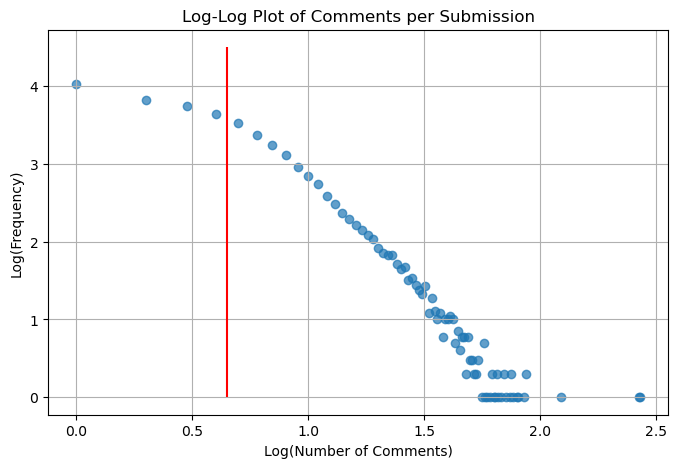

In [20]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

In [ ]:
# select relevant submissions 

relevant_submissions, relevant_comments, empty_submissions, empty_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 4.448746648298934
Nr. of submission, that I have comments for 40651
All submissions found
Removing empty submissions deleted 16574 submissions
Empty submissions in df_submissions_empty: 16574
Kept 24077 submissions
Nr. of comments, whose submission is retaied 128049
Share 0.7080554726120567
Nr. of comments, whose submission is empty 52797
Share 0.29194452738794335


In [25]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

# can keep roughly half of my submissions

Number of relevant submissions: 24077
Lost submissions:  23099


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.355164e+09,14m325,2t160,[deleted],14m325,c7ebuf4,c7ebuf4,-1.0,-1,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
1,Ramblin_Dash,1.355166e+09,14m325,2t160,Regarding Perry vs. Brown (the current name of...,14m325,c7ecp8d,c7ecp8d,7.0,7,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
2,TehNoff,1.355170e+09,14m26x,2t160,So what was wrong with /r/PoliticalDiscussion ...,14m26x,c7edr13,c7edr13,5.0,5,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
3,IBiteYou,1.355171e+09,14m26x,2t160,&gt;We will be adhering to the AskScience styl...,14m26x,c7ee45j,c7ee45j,3.0,3,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
4,[deleted],1.355171e+09,14m18a,2t160,[deleted],14m18a,c7eecqr,c7eecqr,1.0,1,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128044,Much_Cellist8763,1.703372e+09,mh702s,2t160,As soon as we were taken off the gold standard...,mh702s,keo5f9w,keo5f9w,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-23,comment
128045,Extension_Buy_3734,1.703435e+09,xownab,2t160,Except for provider (doctors) who deal in cash...,xownab,ker63l6,ker63l6,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-24,comment
128046,nearmyst,1.703623e+09,14l0zf4,2t160,Biden was the worst candidate on the democrati...,14l0zf4,kf13how,kf13how,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-26,comment
128047,[deleted],1.703741e+09,167034x,2t160,[removed],167034x,kf8a3gp,kf8a3gp,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-28,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [26]:
df_matched, com_per_sub, rep_per_com = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 72018
Nr. of unique comments 47448
Nr. of unique submissions 18804
A submission receives on average 2.5232929164007656 comments.
A comment receives on average 1.5178300455235205 replies.
Share of matched submissions: 0.7809943099223325


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7ebuf4,c7ecmy1,"Well, here's the first comment of this subredd...",Ask_Politics,1.355166e+09,zoolander951,5.0,5,0.0,14m325,...,[deleted],-1.0,-1,0.0,1.355164e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
1,c7ecp8d,c7ecs2n,&gt; Ted Olson and David Boies are extremely g...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
2,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
3,c7ecp8d,c7eflag,SCOTUS has already overridden state law in cas...,Ask_Politics,1.355175e+09,zossima,3.0,3,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
4,c7efx8q,c7ejh1d,I don't think they will either uphold Prop 8 o...,Ask_Politics,1.355188e+09,fathermocker,2.0,2,0.0,14m325,...,senatorskeletor,5.0,5,0.0,1.355176e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72013,fcyrekh,k8kje6m,Apparentlly tho a presedent can and does start...,Ask_Politics,1.699571e+09,Busy-Factor-2542,1.0,1,0.0,ejj4xd,...,Scottlikessports,NaN,6,NaN,1.578085e+09,A friend of mine told me that most of the wars...,Hapouch,NaN,3,1.578075e+09
72014,euh6mgs,k9fn12b,[removed],Ask_Politics,1.700094e+09,[deleted],1.0,1,0.0,cg77fj,...,melechshelyat,NaN,2,NaN,1.563822e+09,When I was looking at Countries by both GDP an...,Zabidi954,NaN,2,1.563761e+09
72015,k9fz0e9,k9wo2gy,Eventually everyone is going to realize that t...,Ask_Politics,1.700413e+09,SecondGuesserIsBack2,-4.0,-4,0.0,17w3s8o,...,Educational-Dance-61,7.0,7,0.0,1.700099e+09,"Yesterday, a lawyer for one of the defendants ...",All_bound_up,10.0,10,1.700082e+09
72016,k9fz0e9,kb8de02,"Man 40 years of biden bribes, collusion, and d...",Ask_Politics,1.701241e+09,Sarasota33907,1.0,1,0.0,17w3s8o,...,Educational-Dance-61,7.0,7,0.0,1.700099e+09,"Yesterday, a lawyer for one of the defendants ...",All_bound_up,10.0,10,1.700082e+09


In [27]:
df_matched_empty, com_per_sub_empty, rep_per_com_empty = match_reply_comment_submission(replies, empty_comments, empty_submissions, 'inner', subreddit_here)
df_matched_empty


Nr. of unique replies 23492
Nr. of unique comments 16350
Nr. of unique submissions 7214
A submission receives on average 2.26642639312448 comments.
A comment receives on average 1.4368195718654435 replies.
Share of matched submissions: 0.43526004585495354


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7caq14,c7cas56,&gt; I think we need to first define exactly w...,Ask_Politics,1.354822e+09,karmanaut,1.0,1,0.0,14eb25,...,mr_majorly,4.0,4,0.0,1.354822e+09,,karmanaut,2.0,2,1.354821e+09
1,c7cb8bt,c7cb94u,I'd be in favor of allowing non-experts to ans...,Ask_Politics,1.354824e+09,karmanaut,1.0,1,0.0,14eb25,...,WhirledWorld,1.0,1,0.0,1.354824e+09,,karmanaut,2.0,2,1.354821e+09
2,c7cb8bt,c7cbg82,A few people I went to college with would be p...,Ask_Politics,1.354824e+09,nallen,3.0,3,0.0,14eb25,...,WhirledWorld,1.0,1,0.0,1.354824e+09,,karmanaut,2.0,2,1.354821e+09
3,c7ecn3d,c7ed21g,Why grant cert though for such a narrow holdin...,Ask_Politics,1.355167e+09,WhirledWorld,7.0,7,0.0,14m72s,...,karmanaut,4.0,4,0.0,1.355166e+09,,WhirledWorld,8.0,8,1.355165e+09
4,c7emvxk,c7epqll,"You mentioned outright voter fraud, is this a ...",Ask_Politics,1.355210e+09,ObjectiveTits,4.0,4,0.0,14n14m,...,JordanLeDoux,112.0,112,0.0,1.355199e+09,,[deleted],25.0,25,1.355190e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23487,k70xzku,k8ghtgw,This about sums it up. The process behind the ...,Ask_Politics,1.699502e+09,Xia-Kaisen,1.0,1,0.0,177at5a,...,TalentedThots,1.0,1,0.0,1.698625e+09,[removed],StingingGolf395,1.0,1,1.697237e+09
23488,kb757gv,kbl3o9v,Can you point to the Alabama vote? I can't fin...,Ask_Politics,1.701458e+09,ProLifePanda,1.0,1,0.0,17qram9,...,Sorcerer1987,1.0,1,0.0,1.701220e+09,[removed],AdoorMe,1.0,1,1.699466e+09
23489,kdt7q6p,kdtx1u8,"I sympathize with that, but palestinians would...",Ask_Politics,1.702861e+09,Nana_2910,1.0,1,0.0,18ks4k6,...,TheGraby,1.0,1,0.0,1.702851e+09,[removed],Nana_2910,1.0,1,1.702849e+09
23490,kdh8lxx,kfcbk6e,> for no good reason\n\nThere is now a good re...,Ask_Politics,1.703808e+09,PlinyToTrajan,1.0,1,0.0,17rdjdw,...,white_nerdy,1.0,1,0.0,1.702656e+09,[removed],viragoria,1.0,1,1.699538e+09


In [34]:

com_per_sub_empty = com_per_sub_empty.rename(columns={0 : 'nr_comments'})
rep_per_com_empty = rep_per_com_empty.rename(columns={0 : 'nr_replies'})

com_per_sub = com_per_sub.rename(columns={0 : 'nr_comments'})
rep_per_com = rep_per_com.rename(columns={0 : 'nr_replies'})


df_matched.to_csv(f"output/{subreddit_here}_df_matched.csv", index = False)
com_per_sub.to_csv(f"output/{subreddit_here}_com_per_sub.csv", index = False)
rep_per_com.to_csv(f"output/{subreddit_here}_rep_per_com.csv", index = False)

df_matched_empty.to_csv(f"output/{subreddit_here}_df_matched_empty.csv", index = False)
com_per_sub_empty.to_csv(f"output/{subreddit_here}_com_per_sub_empty.csv", index = False)
rep_per_com_empty.to_csv(f"output/{subreddit_here}_rep_per_com_empty.csv", index = False)

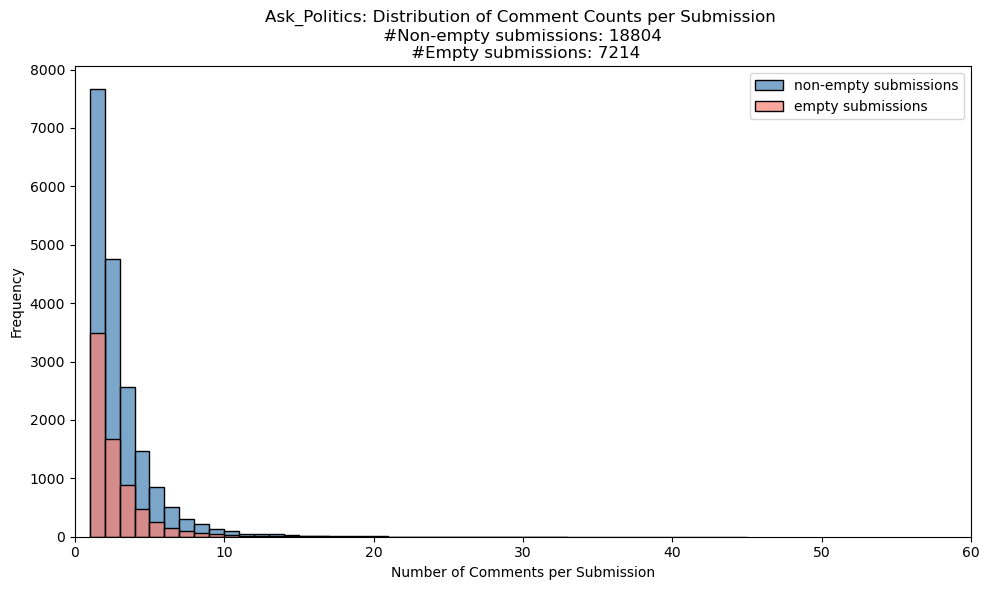

In [19]:

plt.figure(figsize=(10, 6))

sns.histplot(com_per_sub[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(com_per_sub_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)

plt.xlabel('Number of Comments per Submission')
plt.xlim(0,60)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Hist_{subreddit_here}_Comment_per_Submission.pdf")
plt.show()

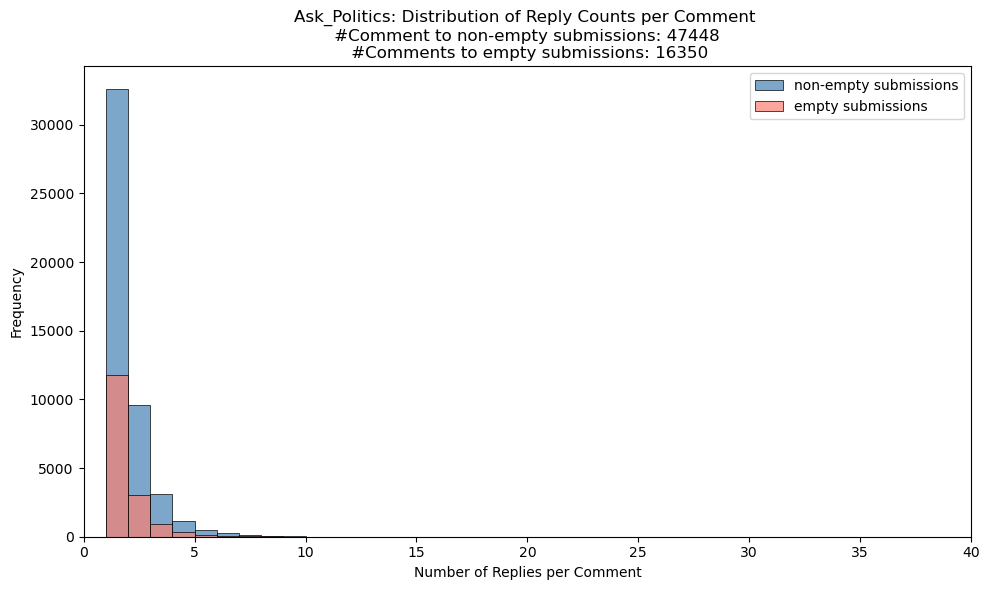

In [20]:

plt.figure(figsize=(10, 6))


sns.histplot(rep_per_com[0], binwidth=1, kde=False, label='non-empty submissions', color='steelblue', alpha=0.7)
sns.histplot(rep_per_com_empty[0], binwidth=1, kde=False, label='empty submissions', color='salmon', alpha=0.7)


plt.xlabel('Number of Replies per Comment')
plt.xlim(0, 40)
plt.ylabel('Frequency')
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.legend()
plt.tight_layout()

plt.savefig(f"Hist_{subreddit_here}_Replies_per_Comment.pdf")
plt.show()

C:\Users\3leso\AppData\Local\Temp\ipykernel_10552\1603355170.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


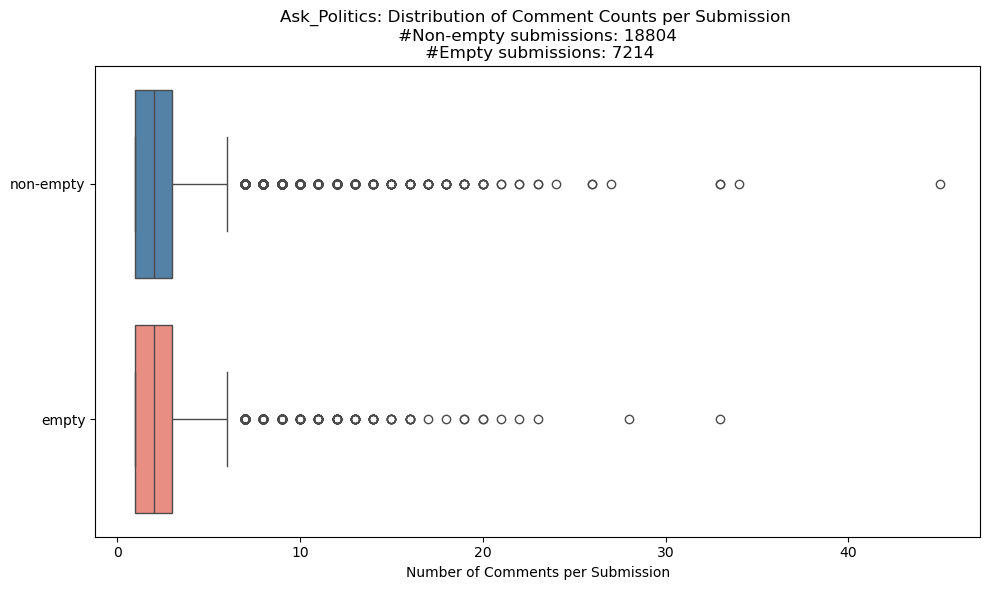

In [21]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([com_per_sub[0], com_per_sub_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(com_per_sub[0]) + ['empty'] * len(com_per_sub_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Comments per Submission')
plt.ylabel('')
#plt.xlim(0, 100)
plt.title(f'{subreddit_here}: Distribution of Comment Counts per Submission \n #Non-empty submissions: {len(com_per_sub[0])} \n #Empty submissions: {len(com_per_sub_empty[0])}')
plt.savefig(f"Box_{subreddit_here}_Comments_per_Submission.pdf")

plt.tight_layout()
plt.show()

C:\Users\3leso\AppData\Local\Temp\ipykernel_10552\3153005790.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])


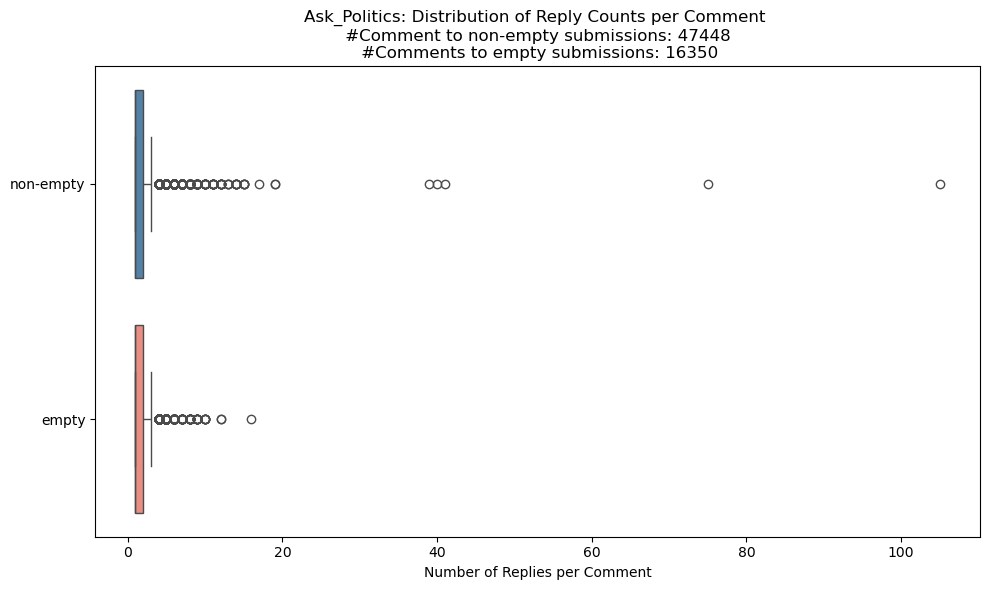

In [22]:
plt.figure(figsize=(10, 6))

df_box = pd.DataFrame({
    'comments': pd.concat([rep_per_com[0], rep_per_com_empty[0]], ignore_index=True),
    'type': ['non-empty'] * len(rep_per_com[0]) + ['empty'] * len(rep_per_com_empty[0])
})


# Create vertically stacked boxplots
sns.boxplot(data=df_box, x='comments', y='type', orient='h', palette=['steelblue', 'salmon'])

plt.xlabel('Number of Replies per Comment')
plt.ylabel('')
#plt.xlim(0, 80)
plt.title(f'{subreddit_here}: Distribution of Reply Counts per Comment \n #Comment to non-empty submissions: {len(rep_per_com[0])} \n #Comments to empty submissions: {len(rep_per_com_empty[0])}')
plt.savefig(f"Box_{subreddit_here}_Replies_per_Comment.pdf")

plt.tight_layout()
plt.show()

In [22]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [23]:
df_matched['body_child'].value_counts().head(10)

df_matched['body_parent'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*
# I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

# don't filter based on frequency of a text
# short replies (like thank you), will be removed with len < 5
# frequent comments can just be active comments
# bots are removed by author = [removed]


body_parent
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [24]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 8593 interactions. Share:  0.11931739287400372
Kept 63425 interactions.
Deleting empty authors deleted 5832 interactions. Share:  0.09195112337406386
Kept 57593 interactions.


KeyboardInterrupt: 

In [ ]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


## **Check for Mods**

In [ ]:
df['author_submission'].value_counts()[:20]

author_submission
AuditorTux             828
chinmakes5             479
hermannschultz13       312
benjaminikuta          255
gomi-panda             180
sammyjamez             163
Unlucky_Outside        151
Shr3kk_Wpg             150
Experimentalphone      138
Real_Carl_Ramirez      125
SGP_MikeF              122
MillenniumGreed        121
Marisa_Nya             108
MeenaBeti              103
jcdulos                 96
AlexKingstonsGigolo     93
mafternoonshyamalan     90
aliygdeyef              86
Freud_fucked_my_mom     86
tamayimpala             86
Name: count, dtype: int64

In [ ]:
df['author_parent'].value_counts()[:20]

author_parent
mormagils               680
AuditorTux              605
VVillyD                 485
thisfunnieguy           481
wjbc                    416
Trekky0623              392
gsfgf                   350
Dennis_Langley          324
SovietRobot             302
JudgeWhoOverrules       300
NYSenseOfHumor          299
Cleomenes_of_Sparta     290
houinator               287
tayaravaknin            285
Volsunga                278
Peen_Envy               271
Love_Shaq_Baby          269
Impune                  261
pluralofjackinthebox    242
zlefin_actual           219
Name: count, dtype: int64

In [ ]:
df['author_child'].value_counts()[:20]

author_child
AuditorTux             596
TeddysBigStick         398
thisfunnieguy          375
gsfgf                  371
chinmakes5             256
Dennis_Langley         228
tayaravaknin           198
Peen_Envy              171
cuteman                156
Adam_df                153
SovietRobot            151
Cleomenes_of_Sparta    151
Arthur_Edens           148
polioperativeAMA       147
matts2                 143
VVillyD                141
overzealous_dentist    140
AlexKingstonsGigolo    134
Shr3kk_Wpg             133
RomanNumeralVI         130
Name: count, dtype: int64

### Save and export

In [ ]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
2,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,1.355170e+09,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
3,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
4,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,1.355171e+09,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54257,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,1.701905e+09,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,1.552664e+09,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,1.552662e+09
54258,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,1.702175e+09,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,1.580156e+09,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,1.580084e+09
54259,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,1.702416e+09,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,1.688412e+09,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,1.688317e+09
54260,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,1.702431e+09,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,1.550918e+09,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,1.550913e+09


***
## **Descriptive Stats**

In [ ]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

63102
Unique Users:  51209


### Time Stats and originally pulled counts

In [ ]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


Time Frame 
---------------------------------------------
Beginning of time frame: 2012-12-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 47176
Number of comments and replies: 532593
---------------------------------------------



### Descriptive Stats after Matching

In [ ]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  72018
Number of unique comments:  47448
Number of unique submissions:  18804


### Descriptive Stats after cleaning for high quality texts

In [ ]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  54262
Unique Comments:  37492
Unique Submissions:  16476


In [ ]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  24428
